In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import tensorflow as tf
from skimage import io
import os
import glob
import random
import pandas as pd
import shutil
from PIL import Image,ImageDraw

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from tensorflow.keras.applications import VGG16

In [3]:
os.chdir('../')
path = 'images/Set4'

In [2]:
def filterImages():
    for dir in os.listdir(path):
        for file in os.listdir(path+'/'+dir):
            if file.endswith('txt'):
                lines = np.loadtxt(path+'/'+dir+'/'+file)
                if lines.size == 5:
                    img = file.split('.')[0]+'.jpg'
                    shutil.copy(path+'/'+dir+'/'+img,f"images/Set4/{dir}")
                    shutil.copy(path+'/'+dir+'/'+file,f"images/Set4/{dir}")
                else:
                    continue

In [5]:
#Check to see if bounding boxes are actually correct
#Manually Apply Bounding Boxes with the help of labels.txt provided along with the Missouri Datasets
data = np.loadtxt(path+'/buffalo/002.txt')
im = Image.open(path+'/buffalo/002.jpg')
w = im.size[0]
h = im.size[1]
x = data[1]*w
y = data[2]*h
width = data[3]*w
height = data[4]*h
draw = ImageDraw.Draw(im)
draw.rectangle((x-width/2,y-height/2,x+width/2,y+height/2),width=1)
im.show()
im.close()
       

In [10]:
x_loc = np.zeros((843, 50176, 3), dtype=float)
y_loc = np.zeros(843, dtype=int)
bbox = np.zeros((843,4), dtype=float)
i=0
for dir in os.listdir(path):
    for file in os.listdir(path+'/'+dir):
        if file.endswith('jpg'):
            org_img = tf.keras.preprocessing.image.load_img(path+'/'+dir+'/'+file).resize((224,224))
            org_img_to_array = tf.keras.preprocessing.image.img_to_array(org_img)
            reshaped_img = org_img_to_array.reshape(-1,3)/255.0
            x_loc[i,:,:] = reshaped_img
        else:
            line = np.loadtxt(path+'/'+dir+'/'+file)
            bbox[i,:] = line[1:]
            y_loc[i] = line[0]
            i = i+1
print('writing to the file')

with open('x_loc.npy','wb') as f:
    np.save(f,x_loc)
with open('y_loc.npy', 'wb') as f:
    np.save(f, y_loc)
with open('bbox.npy', 'wb') as f:
    np.save(f, bbox)

writing to the file


In [4]:
with open('x_loc.npy','rb') as f:
    x = np.load('x_loc.npy')
with open('y_loc.npy', 'rb') as f:
    y = np.load('y_loc.npy')
with open('bbox.npy', 'rb') as f:
    z = np.load('bbox.npy')

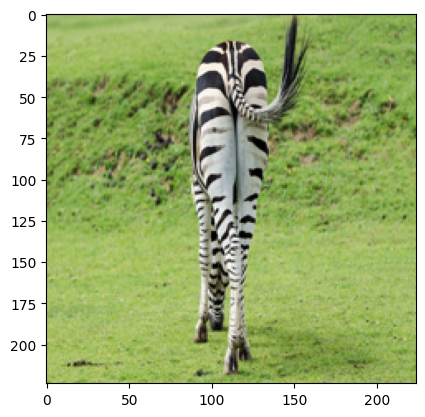

In [5]:
first = tf.keras.preprocessing.image.array_to_img(x[842].reshape(224,224,3))
plt.imshow(first)

In [6]:
X_train, X_, y_train, y_ , z_train, z_ = train_test_split(x, y, z, random_state=False, test_size=0.2, shuffle=True)
X_test, X_val, y_test, y_val, z_test, z_val = train_test_split(X_, y_, z_, random_state=False, test_size=0.5, shuffle=True)

In [13]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(4, activation="softmax", name="class_label")(softmaxHead)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

model = tf.keras.Model(inputs=vgg.input, outputs=(softmaxHead,bboxHead))

In [14]:
losses = {
    "class_label": "sparse_categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [15]:
model.compile(loss=losses, optimizer='adam', loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [16]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": y_train,
    "bounding_box": z_train
}
# construct a second dictionary, this one for our target testing
# outputs
valTargets = {
    "class_label": y_val,
    "bounding_box": z_val
}

In [17]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
history = model.fit(X_train.reshape(-1,224,224,3),trainTargets, validation_data=(X_val.reshape(-1,224,224,3),valTargets), batch_size=25, epochs=10, verbose=1)

[INFO] training bounding box regressor...
Epoch 1/10
27/27 [==============================] - 15s 343ms/step - loss: 3.3219 - class_label_loss: 3.2817 - bounding_box_loss: 0.0402 - val_loss: 0.8952 - val_class_label_loss: 0.8852 - val_bounding_box_loss: 0.0100
Epoch 2/10
27/27 [==============================] - 4s 166ms/step - loss: 0.9245 - class_label_loss: 0.9176 - bounding_box_loss: 0.0070 - val_loss: 0.6160 - val_class_label_loss: 0.6085 - val_bounding_box_loss: 0.0075
Epoch 3/10
27/27 [==============================] - 4s 164ms/step - loss: 0.7341 - class_label_loss: 0.7304 - bounding_box_loss: 0.0036 - val_loss: 0.5270 - val_class_label_loss: 0.5204 - val_bounding_box_loss: 0.0065
Epoch 4/10
27/27 [==============================] - 4s 165ms/step - loss: 0.6373 - class_label_loss: 0.6352 - bounding_box_loss: 0.0021 - val_loss: 0.3452 - val_class_label_loss: 0.3390 - val_bounding_box_loss: 0.0062
Epoch 5/10
27/27 [==============================] - 4s 165ms/step - loss: 0.4948 - cl

In [18]:
model.save('models/wildlife_loc.h5')

In [7]:
from tensorflow.keras.models import load_model
model = load_model('models/wildlife_loc.h5')

In [8]:
X_test.shape
X_val.shape

(85, 50176, 3)

1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - class_label_loss: 0.0000e+00 - bounding_box_loss: 0.0000e+00


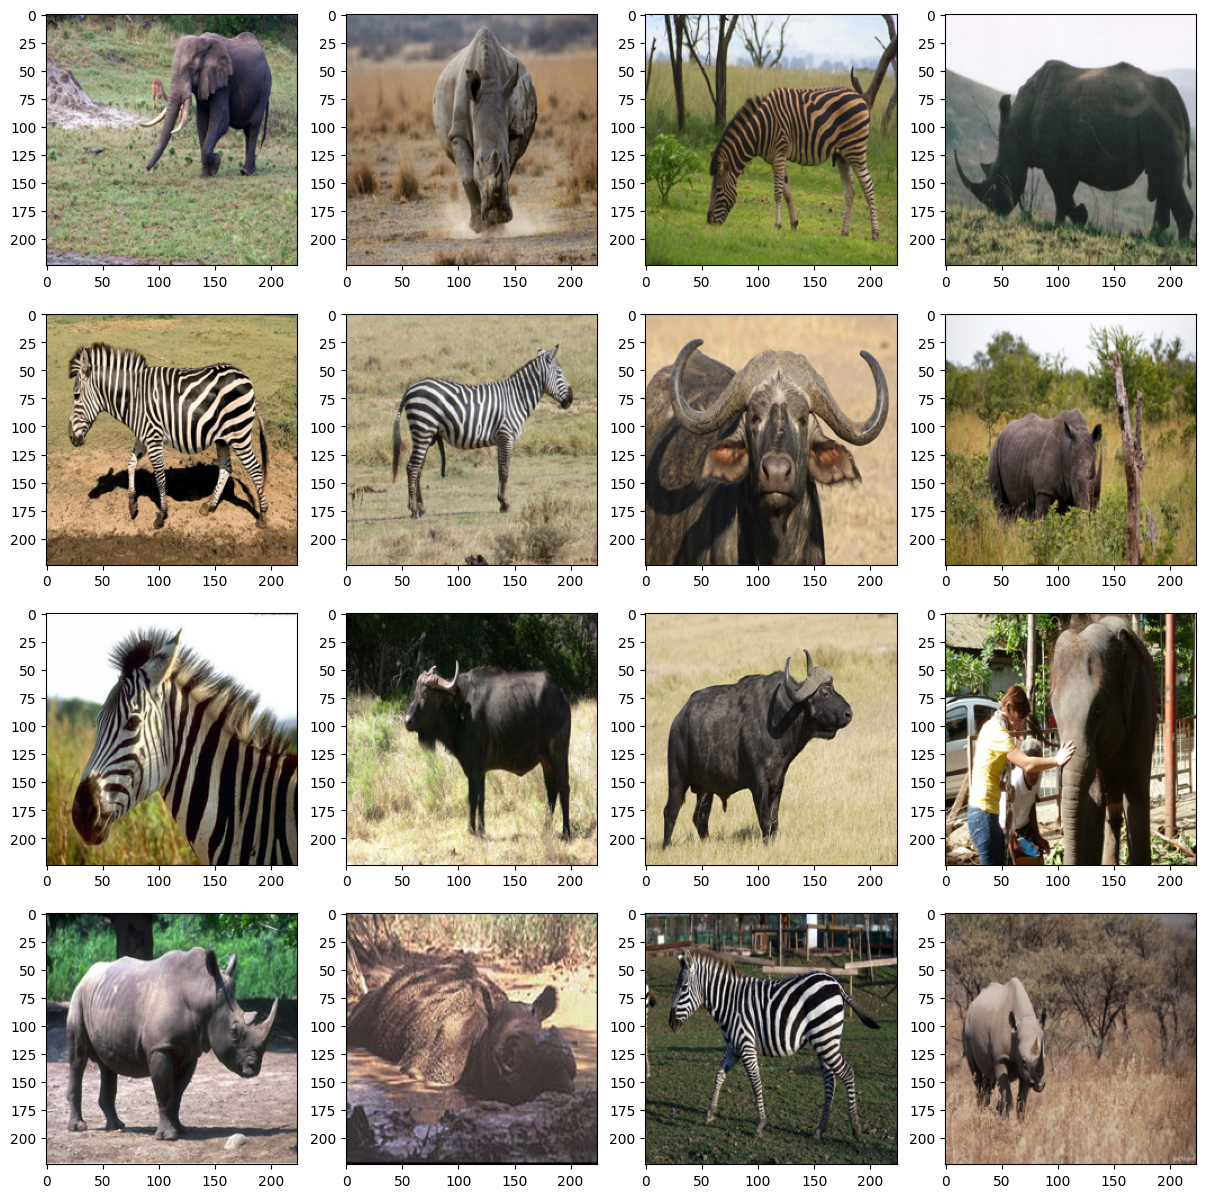

In [18]:
fig,axes = plt.subplots(4,4,figsize=(12,12))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    randomindex = np.random.randint(84)
    prediction = model.predict(X_test[randomindex].reshape(-1,224,224,3))
    X_random = X_test[randomindex].reshape(224,224,3)
    (x,y,width,height) = prediction[1][0]
    ax.imshow(X_random,cmap="gray")
    ax.add_patch(Rectangle(((x-width/2)*224,(y-height/2)*224), width*224, height*224, edgecolor='red',facecolor='none',lw=1))
    ax.text((x-width/2)*224,(y-height/2)*224,f"{y_test[randomindex]},{np.argmax(prediction[0][0])}",c='blue',fontsize=16)
    ax.set_axis_off()